In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

imports successful


In [ ]:
#Assignment: 
#In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, 
#you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. 
#Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

#Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. 
#Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

    #overall test-set accuracy, measured however you think is appropriate
    #show some of the example images from the test set, together with your model's predicted classes.
    #a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).


C:\Users\jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/6, Loss: 0.8334320028622945
Epoch 2/6, Loss: 0.27054362148046496
Epoch 3/6, Loss: 0.22366561939318974
Epoch 4/6, Loss: 0.11078990747531255
Epoch 5/6, Loss: 0.08289696946740151
Epoch 6/6, Loss: 0.05903129850824674
Test Accuracy: 90.41666666666667%


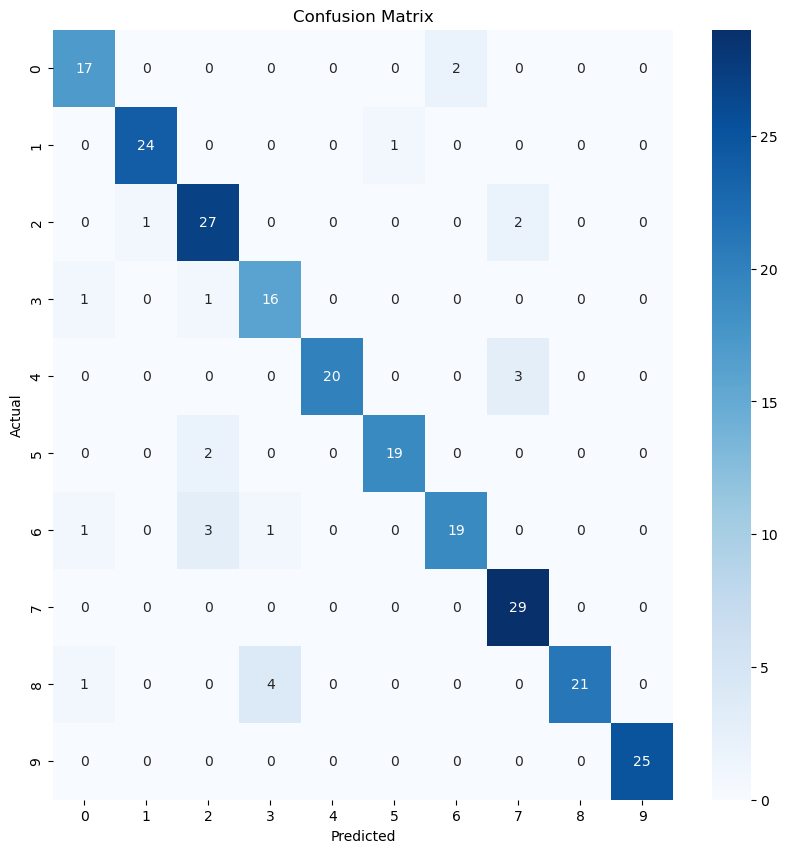

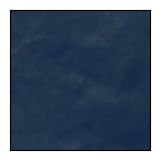

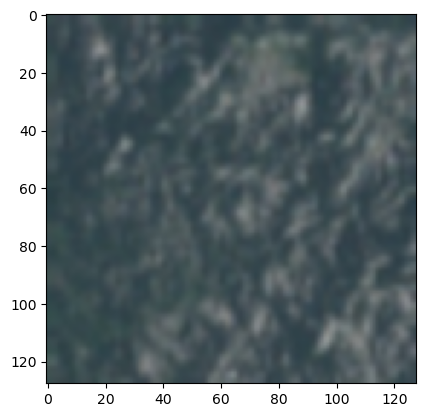

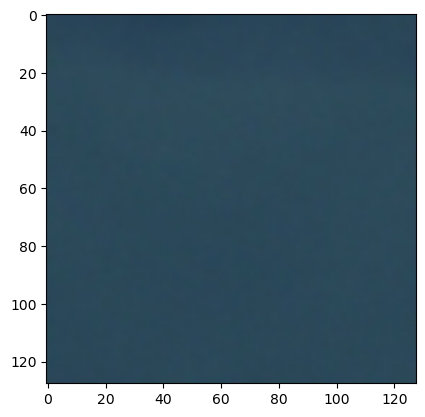

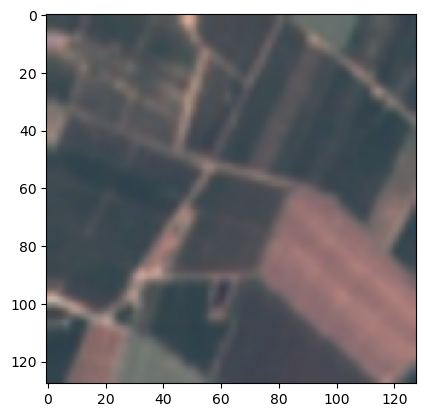

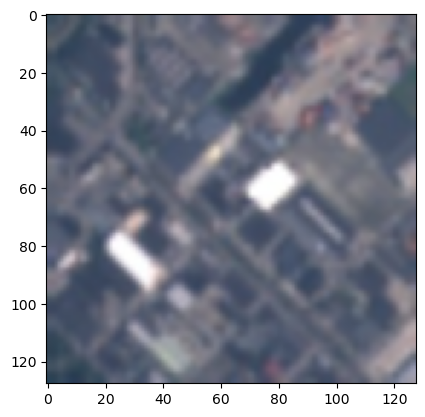

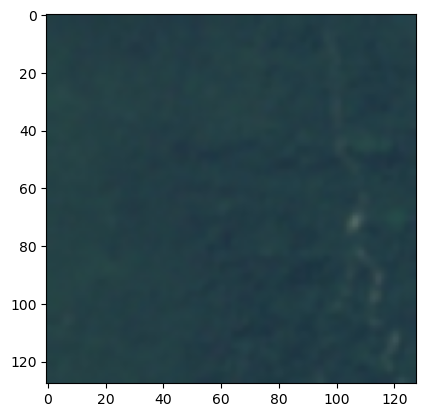

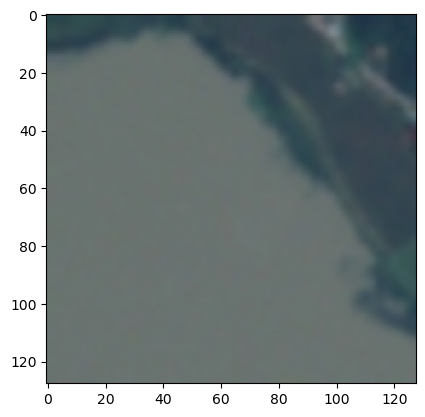

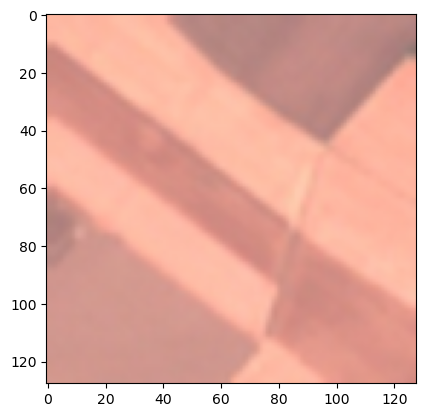

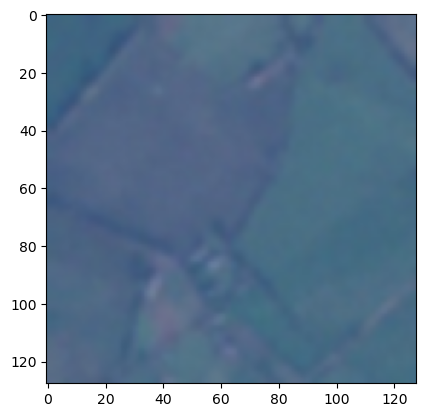

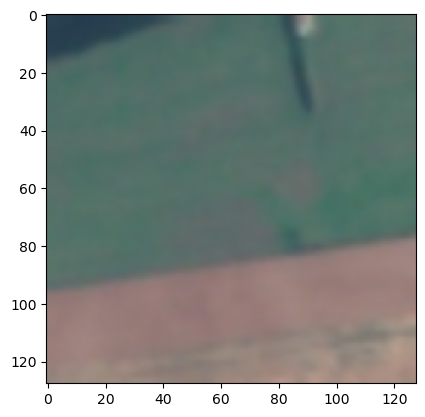

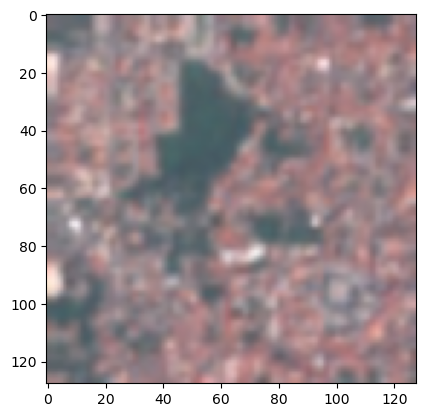

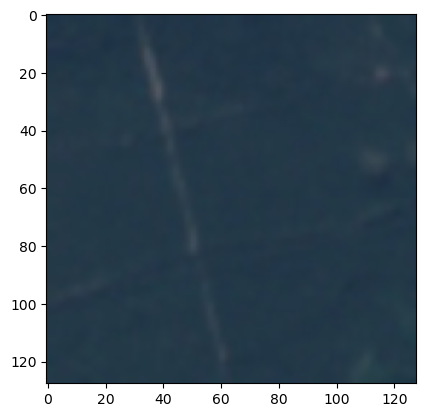

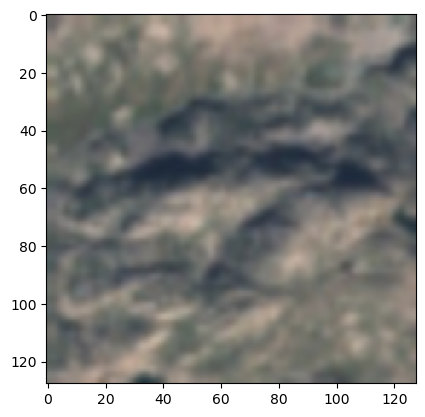

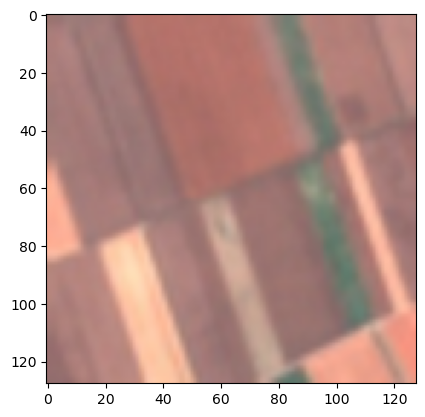

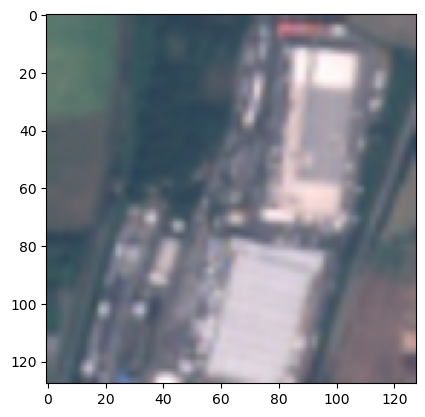

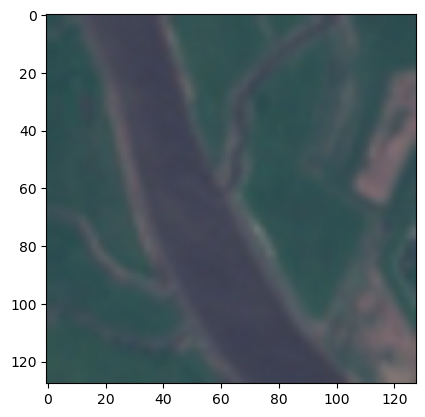

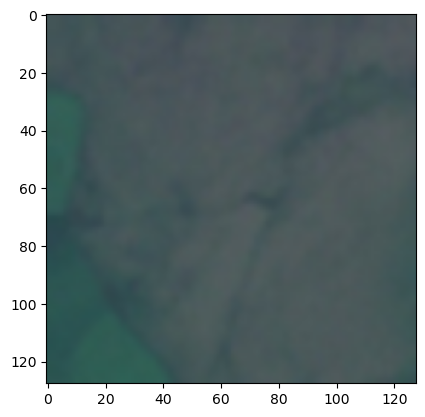

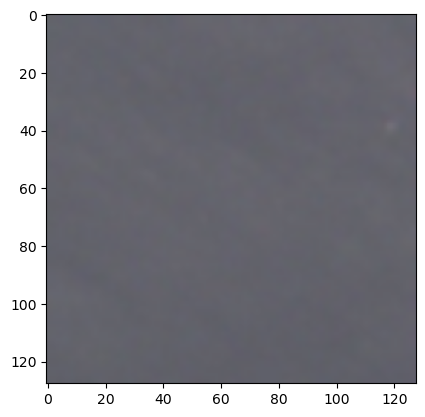

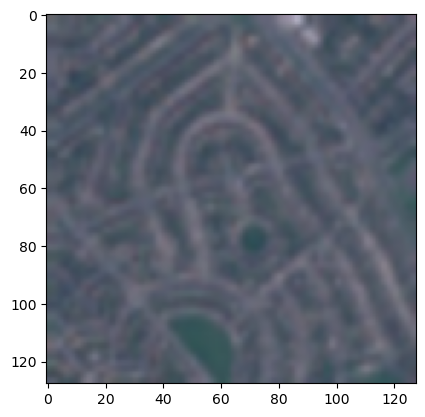

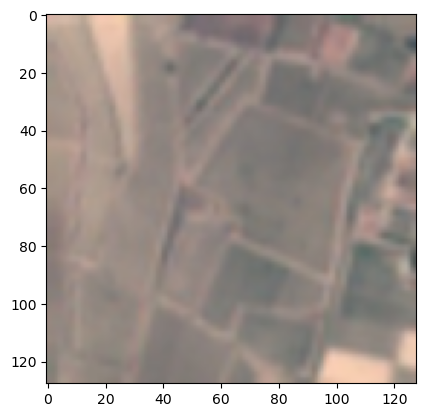

In [30]:
#It takes roughly 2 minutes to run this script on a machine w/16gb ram.
#You can change the subset_size and num_epoch variables to slightly improve neural network accuracy at the expense of more processing time, or vice versa.
#However, improvements in accuracy are very small when making further adjustments. For example, running this with 10,000 pictures and 10 epochs
#gives you 93% accuracy; 1,000 pictures and 5 epochs takes a fraction of the time and generates 90% accuracy.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load a subset of the dataset
full_dataset = datasets.ImageFolder(root='C:/Users/jason/Downloads/STA380-master/STA380-master/data/EuroSAT_RGB', transform=data_transforms)
subset_size = min(1000, len(full_dataset))  # Accuracy will improve slightly the more images you use here, but processing time goes up as well
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
subset_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Split dataset
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model (using a pre-trained MobileNetV2)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 11)  # 11 classes
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Accuracy will improve slightly the more epochs you use here, but processing time goes up as well
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

# Confusion Matrix and visualizations
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"{full_dataset.classes[preds[idx]]}\n(label: {full_dataset.classes[labels[idx]]})",
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
plt.show()